# Categorical Model Dedicated Notebook

## Data Admin:

50001
0_cam-image_array_.jpg
50001
record_0.json
Image 50000 of 50001
Loaded images on average at 24.365312693746127us
Record 50000 of 50001
Calculated angles on average at 20.077538449231014us
50001
50001
(50001, 100, 100, 3)
23064


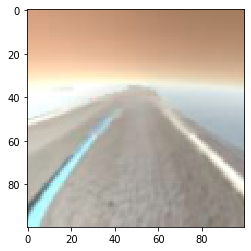

[0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [63]:
import os
import natsort
import numpy as np
import cv2
import json
import tensorflow as tf
from random import randrange
import datetime 

import matplotlib.pyplot as plt

%matplotlib inline

#finding and sorting images and label data: - Unthresholded Images!
# Data using Simulation https://docs.donkeycar.com/guide/simulator/
# Windows Binaries https://github.com/tawnkramer/gym-donkeycar/releases/download/v18.9/DonkeySimWindows.zip
# Additional Binaries and Source https://github.com/tawnkramer/gym-donkeycar/releases
path = 'simdata/'

im_list = []

rec_list = []

for file in os.listdir(path):
    if 'cam' in file:
        im_list.append(file)
    elif 'record' in file:
        rec_list.append(file)

print(len(im_list))
print(im_list[0])
print(len(rec_list))
print(rec_list[0])

im_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
rec_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

#reading in array of images:
width = 100#160
height = 100#120
color = 3
x_images = np.zeros((len(rec_list), height, width, color), dtype = np.float32)

randomImage = randrange(len(x_images))#14909
preprocessDelta = np.zeros(len(rec_list), dtype = np.uint8)
for i in range(len(im_list)):
    start = datetime.datetime.now()
    filename = im_list[i]
    image = cv2.imread(path+filename)
    image = cv2.resize(image,(height,width),interpolation = cv2.INTER_AREA)
    #beta = 100-(np.average(image)/255)*100
    #image = cv2.convertScaleAbs(image, alpha=1.0, beta=beta)    
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #image = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,11,2)
    #image = image.astype('uint8')
    #image = image[..., None]
    #x_images[i,:,:,:] = tf.cast(image[..., None], tf.float32)
    x_images[i,:,:,:] = tf.cast(image, tf.float32)
    end = datetime.datetime.now()
    preprocessDelta[i] = (end-start).microseconds
    if (i>=1000)and(i % 1000 == 0):
        print(f'Image {i} of {len(im_list)}', end='\r')
    
print('')
def getAngle(orient):
    angle = [0,0,0,0,0,0,0,0,0]
    if orient > (35.0/45.0):
        angle = [0,0,0,0,0,0,0,0,1] #35+ right
    elif orient > (25.0/45.0):
        angle = [0,0,0,0,0,0,0,1,0] #25+ right
    elif orient > (15.0/45.0):
        angle = [0,0,0,0,0,0,1,0,0] #15+ right
    elif orient > (5.0/45.0):
        angle = [0,0,0,0,0,1,0,0,0] #5+ right
    elif orient < -1*(35.0/45.0):
        angle = [1,0,0,0,0,0,0,0,0] #35+ left
    elif orient < -1*(25.0/45.0):
        angle = [0,1,0,0,0,0,0,0,0] #25+ left
    elif orient < -1*(15.0/45.0):
        angle = [0,0,1,0,0,0,0,0,0] #15+ left
    elif orient < -1*(5.0/45.0):
        angle = [0,0,0,1,0,0,0,0,0] #5+ left
    else:
        angle = [0,0,0,0,1,0,0,0,0] #0 straight
    return angle
        
print(f'Loaded images on average at {np.average(preprocessDelta)}us')
json_data = {}
y_labels = np.zeros((len(rec_list),9), dtype=np.float32)
#[-35,-25,-15,-5,0,5,15,25,35]
for i in range(len(rec_list)):
    start = datetime.datetime.now()
    filename = rec_list[i]
    with open(path+filename) as fp:
        json_data = json.load(fp)
        orient = json_data['user/angle']
        orient = float(orient)
        y_labels[i] = getAngle(orient)
    end = datetime.datetime.now()
    preprocessDelta[i] = (end-start).microseconds
    if (i>=1000)and(i % 1000 == 0):
        print(f'Record {i} of {len(im_list)}', end='\r')
            
print('')
print(f'Calculated angles on average at {np.average(preprocessDelta)}us')
print(len(x_images))
print(len(y_labels))
print(x_images.shape)
print(randomImage)
plt.imshow(x_images[randomImage].astype('uint8'))
plt.show()
print(y_labels[randomImage])

(50001, 9)
49700
(35002, 100, 100, 3)
(15001, 100, 100, 3)
(35002, 9)
(15001, 9)
[0. 0. 0. 1. 0. 0. 0. 0. 0.]


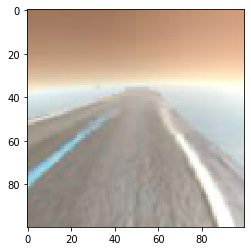

In [44]:
#training and validation split:

memv = 0
memt = 0
x_val = np.zeros((round(len(x_images)*0.3)+1,height, width, color), dtype=np.float32)
x_train = np.zeros((round(len(x_images)*0.7)+1,height, width, color), dtype=np.float32)
y_val = np.zeros((round(len(x_images)*0.3)+1,9), dtype=np.float32)
y_train = np.zeros((round(len(x_images)*0.7)+1,9), dtype=np.float32)

n=0
print(y_labels.shape)

for i in range(len(x_images)):
    if (i>=1000)and(i % 1000 == 0):
        j = i - 300
        k = i - 1000
        print(j, end='\r')
        o = 0
        p = 0
        for l in range(0+n*300, n*300+300):
            x_val[l] = x_images[j+o,:,:,:]
            y_val[l] = y_labels[j+o]
            o +=1
        for m in range(0+n*700, n*700+700):
            x_train[m] = x_images[k+p,:,:,:]
            y_train[m] = y_labels[k+p]
            p+=1
        n+=1
print('')
print(x_train.shape)
print(x_val.shape)

print(y_train.shape)
print(y_val.shape)

print(y_val[1000])
plt.imshow(x_val[1000].astype('uint8'))
plt.show()
#obtaining test data

#relabeling test data

## Model Setup:

In [61]:
import os
import numpy as np

from tensorflow.python import keras
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Convolution2D, MaxPooling2D, Reshape, BatchNormalization
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Cropping2D, Lambda

#Model Structure Setup: no dropout, no regularization yet

model = Sequential()
#Number of feature maps
#Kernel size matrix (thing that looks at picture)
#Strides is how kernel moves accross the image
#Activation is activation algorithm
#Input shape is the image
model.add(Convolution2D(32, (10,10), strides=(5,5), activation='relu', input_shape=(height, width, color)))
model.add(Convolution2D(64, (5,5), strides=(3,3), activation='relu'))
model.add(Convolution2D(64, (3,3), strides=(2,2), activation='relu'))
model.add(Convolution2D(128, (2,2), strides=(1,1), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(9, activation='softmax'))

model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 19, 19, 32)        9632      
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 5, 5, 64)          51264     
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 2, 2, 64)          36928     
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 1, 1, 128)         32896     
_________________________________________________________________
flatten_13 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_37 (Dense)             (None, 32)              

## Training and Validation:

In [62]:
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), shuffle=True, verbose=1)

Train on 35002 samples, validate on 15001 samples
Epoch 1/20
35002/35002 [==============================] - 39s 1ms/sample - loss: 0.7602 - accuracy: 0.7156 - val_loss: 0.4195 - val_accuracy: 0.8331
Epoch 2/20
35002/35002 [==============================] - 37s 1ms/sample - loss: 0.3518 - accuracy: 0.8527 - val_loss: 0.4042 - val_accuracy: 0.8327
Epoch 3/20
35002/35002 [==============================] - 36s 1ms/sample - loss: 0.3100 - accuracy: 0.8727 - val_loss: 0.4183 - val_accuracy: 0.8327
Epoch 4/20
35002/35002 [==============================] - 37s 1ms/sample - loss: 0.2893 - accuracy: 0.8810 - val_loss: 0.3333 - val_accuracy: 0.8629
Epoch 5/20
35002/35002 [==============================] - 36s 1ms/sample - loss: 0.2699 - accuracy: 0.8878 - val_loss: 0.3244 - val_accuracy: 0.8679
Epoch 6/20
35002/35002 [==============================] - 36s 1ms/sample - loss: 0.2708 - accuracy: 0.8870 - val_loss: 0.3500 - val_accuracy: 0.8580
Epoch 7/20
35002/35002 [==============================] 

In [64]:
# Let's Evaluate
test_loss, test_acc = model.evaluate(x_val,  y_val, verbose=2)
print(test_acc)

15001/1 - 5s - loss: 0.4970 - accuracy: 0.8833
0.88334113


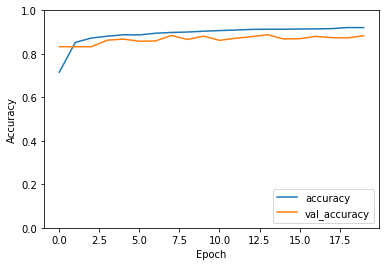

In [65]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

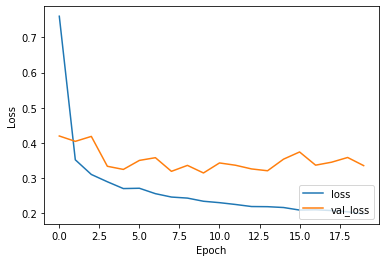

In [66]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

Expected
[0. 0. 0. 0. 1. 0. 0. 0. 0.]
Predicted
[0. 0. 0. 0. 1. 0. 0. 0. 0.]


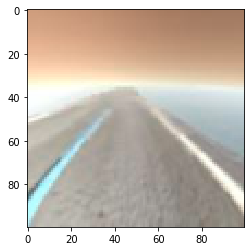

Expected
[0. 0. 0. 0. 1. 0. 0. 0. 0.]
Predicted
[0. 0. 0. 0. 1. 0. 0. 0. 0.]


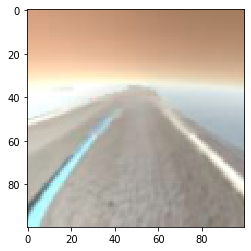

Expected
[0. 0. 0. 0. 1. 0. 0. 0. 0.]
Predicted
[0. 0. 0. 0. 1. 0. 0. 0. 0.]


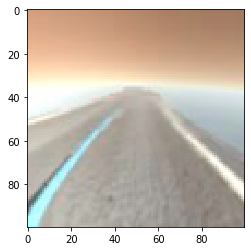

In [67]:
out = model.predict(x_images, batch_size=200)
out = np.around(out)

pointOne = randomImage
pointTwo = randomImage
pointThree = randomImage

if randomImage >= 100:
    pointOne = randomImage - 100
else:
    pointOne = 0
    
if randomImage <= len(x_images) + 100:
    pointThree = randomImage + 100
else:
    pointThree = len(x_images)

print('Expected')
print(y_labels[pointOne])
print('Predicted')
print(out[pointOne])
plt.imshow(x_images[pointOne].astype('uint8'))
plt.show()

print('Expected')
print(y_labels[pointTwo])
print('Predicted')
print(out[pointTwo])
plt.imshow(x_images[pointTwo].astype('uint8'))
plt.show()

print('Expected')
print(y_labels[pointThree])
print('Predicted')
print(out[pointThree])
plt.imshow(x_images[pointThree].astype('uint8'))
plt.show()